# Neural Network Regularization Techniques

This notebook demonstrates modern regularization techniques for neural networks using PyTorch:

- **Dropout**: Randomly drops neurons during training to prevent co-adaptation
- **Weight Decay (L2 Regularization)**: Penalizes large weights in the optimization objective
- **Early Stopping**: Stops training when validation performance stops improving

These techniques are applied to a custom neural network for MNIST digit classification.

## Key Features

- Flexible architecture with configurable dropout probability
- Optional weight decay in the optimizer
- Early stopping with patience parameter
- Comparison of regularized vs. unregularized models

In this exercise you will build your own neural networks, but this time you need to add regularization in the form of dropout, weight-decay and early-stopping.

Each layer should have the option of using dropout. Your code needs to allow for this flexibility.

Additionally, adding weight-decay and early-stopping should also be optional upon creation.

**NOTE**:
1. You are allowed to use built-in functions from pytorch to incorporate this functionality.

2. We recommend the use of GPUs or Google collab for this exercise.

3. During training and validation, remember when to use `model.train()` and `model.eval()`

Use the below imports, as usual you are allowed to import additional packages, but mention the reason you're using them

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

## a. Implement a regularized model [0.5 points]

In this task, you will implement a custom neural network model using PyTorch. The model should incorporate key features such as **dropout** to improve generalization and prevent overfitting.

**Tasks to implement**:

1. Define the Model Architecture:
  - The model consists of a series of fully connected (FC) layers with ReLU activations in between.
  - Dropout layers are added after each hidden layer, with the probability of dropout specified by the `dropout_p` parameter.
  - The final output layer produces a result that is passed through a Softmax activation for multi-class classification tasks.

**Hint**:
Since you're not implementing a CNN, but rather a simple ANN network, it is recommended to flatten your input images when pushing into the network.

In [2]:
import torch
import torch.nn as nn

class Model(nn.Module):
    """
    A neural network model incorporating dropout.

    Args:
        input_dim (int): Dimensionality of the input features.
        hidden_dim (int): Number of units in each hidden layer.
        out_dim (int): Number of output units (number of classes).
        num_layers (int): Number of hidden layers.
        dropout (list of bool): Specifies which hidden layers will have dropout.
        dropout_p (float): Dropout probability used for the Dropout layers.
    """

    def __init__(self, input_dim, hidden_dim, out_dim, num_layers, dropout, dropout_p):
        super(Model, self).__init__()

        assert len(dropout) == num_layers, "Dropout list length must match number of hidden layers"

        self.layers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()

        # Input layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))

        # Hidden layers
        for i in range(num_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            if dropout[i]:
                self.dropout_layers.append(nn.Dropout(p=dropout_p))
            else:
                self.dropout_layers.append(nn.Identity())

        # Output layer
        self.layers.append(nn.Linear(hidden_dim, out_dim))

        # Softmax activation for output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)

        # Forward pass through the layers
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            x = nn.ReLU()(x)  # Apply ReLU activation
            if i < len(self.dropout_layers):  # Apply dropout if it exists
                x = self.dropout_layers[i](x)

        # Output layer
        x = self.layers[-1](x)
        x = self.softmax(x)  # Apply softmax activation

        return x


### b. Data and code setup [1 + 0.25 + 0.25 = 1.5 points]

You will use the MNIST dataset for these experiments. The data setup has been provided for you.<br> **DO NOT CHANGE THE CODE HERE.**

In [3]:
# Load the data
# DO NOT CHANGE THE CODE IN THIS CELL
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_train))  # 80% for training
val_size = len(mnist_train) - train_size  # 20% for validation

# Split the dataset into training and validation
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [train_size, val_size])

train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.15MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Training code
The `trainer()` function trains a model using the provided data loaders, criterion (loss function), optimizer, and various options for regularization and early stopping. You will implement this function for training models for the experiments.

Few things to keep in mind:
- The function should accept model, data loaders, loss function, optimizer, and training configurations (epochs, early stopping).
- The training loop should include forward pass, loss computation, backward pass, and weight update.
- Track and return average training and validation losses for each epoch.
- Use tqdm for progress bars during training and validation. (**optional**, but recommended)
- Implement **early stopping** to halt training if validation loss doesn't improve for a set number of epochs. Provide a `patience` parameter as the number of epochs to wait until validation loss improves.
  - Make it optional by passing a boolean param `early_stopping`.

In [4]:
import torch
import torch.nn as nn
from tqdm import tqdm

def trainer(model, train_loader, val_loader, criterion, optimizer, epochs=50, early_stopping=False, patience=10):
    """
    Train the model with optional early stopping.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (DataLoader): The training data loader.
        val_loader (DataLoader): The validation data loader.
        criterion (loss function): The loss function.
        optimizer (Optimizer): The optimizer to use.
        epochs (int, optional): The number of epochs to train. Default is 50.
        early_stopping (bool, optional): Whether to apply early stopping. Default is False.
        patience (int, optional): The patience for early stopping. Default is 10.

    Returns:
        model (torch.nn.Module): The trained model.
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        # Training loop
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training")
        for inputs, targets in train_progress:
            inputs, targets = inputs.to(model.device), targets.to(model.device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation")
            for inputs, targets in val_progress:
                inputs, targets = inputs.to(model.device), targets.to(model.device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        # Early stopping
        if early_stopping:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print("Early stopping triggered.")
                model.load_state_dict(torch.load('best_model.pth'))
                break

    return model, train_losses, val_losses


#### Evaluation code

Complete the `plot_losses()` function and `evaluate_model()` to visualize the training and validation losses and to evaluate the model over the test set.

**NOTE**:
1. Add a legend, title, and grid to improve plot readability for `plot_losses()`
2. Report the average test loss, accuracy, and F1 score metrics using `evaluate_model()`.


In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses.

    Args:
        train_losses (list): List of average training losses per epoch.
        val_losses (list): List of average validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, test_loader, criterion):
    """
    Evaluate the model on the test set and report accuracy and F1 score.

    Args:
        model (torch.nn.Module): The trained model to be evaluated.
        test_loader (DataLoader): The test data loader.
        criterion (loss function): The loss function to use for evaluation.

    Returns:
        float: The average test loss.
        float: The accuracy of the model on the test set.
        float: The F1 score of the model on the test set.
    """
    model.eval()
    running_test_loss = 0.0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(model.device), targets.to(model.device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_test_loss += loss.item()

            predictions = torch.argmax(outputs, dim=1)
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    avg_test_loss = running_test_loss / len(test_loader)
    accuracy = accuracy_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

    return avg_test_loss, accuracy, f1


## c. Experiments: [0.25+0.25+0.25+0.25 = 1 point]
Build a deep network using 3 hidden layers, so in total including input and output layers, it shoudl be a 5-layer network. You will run the following 4 experiments on this network with the given configurations:

1. Deep network (at least 3 hidden layers)
2. Deep regularized network (with weight-decay enabled)
3. Deep regularized network (with weight-decay and dropout)
4. Deep regularized network (with weight-decay and early-stopping)

Report Accuracy and $F_1$ metrics on the `test set` for your experiments and discuss your results. What did you expect to see and what did you end up seeing.

**NOTE**:
- You can choose how you use regularization. Ideally you would experiment with various parameters for this regularization, the 4 listed variants are merely what you must cover as a minimum. You are free to run more experiments if you want to.
- In the end, report results for all your experiments on the test set concisely  in a table at the end.
- Use the Adam optimizer for all of your experiments.

### Experiment 1: Deep network (at least 3 hidden layers) (No Regularization)

Use the given model configs and hyperparams to run the experiments.

In [6]:
import torch.optim as optim

# Deep network (3 hidden layers) with no dropout and no weight-decay
model_1_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}


learning_rate = 5e-5
weight_decay = 0  # Use this only if weight-decay is needed

Epoch 1/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 55.81it/s]


Epoch 1/50: Train Loss = 1.8179, Val Loss = 1.6604


Epoch 2/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 66.75it/s]


Epoch 2/50: Train Loss = 1.6333, Val Loss = 1.5887


Epoch 3/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 71.81it/s]


Epoch 3/50: Train Loss = 1.5727, Val Loss = 1.5690


Epoch 4/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.44it/s]


Epoch 4/50: Train Loss = 1.5554, Val Loss = 1.5591


Epoch 5/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 67.35it/s]


Epoch 5/50: Train Loss = 1.5460, Val Loss = 1.5506


Epoch 6/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 55.86it/s]


Epoch 6/50: Train Loss = 1.5388, Val Loss = 1.5428


Epoch 7/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.40it/s]


Epoch 7/50: Train Loss = 1.5318, Val Loss = 1.5346


Epoch 8/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.10it/s]


Epoch 8/50: Train Loss = 1.5263, Val Loss = 1.5307


Epoch 9/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.68it/s]


Epoch 9/50: Train Loss = 1.5216, Val Loss = 1.5265


Epoch 10/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 53.09it/s]


Epoch 10/50: Train Loss = 1.5177, Val Loss = 1.5210


Epoch 11/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 60.59it/s]


Epoch 11/50: Train Loss = 1.5133, Val Loss = 1.5182


Epoch 12/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.47it/s]


Epoch 12/50: Train Loss = 1.5103, Val Loss = 1.5161


Epoch 13/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.36it/s]


Epoch 13/50: Train Loss = 1.5067, Val Loss = 1.5149


Epoch 14/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.40it/s]


Epoch 14/50: Train Loss = 1.5046, Val Loss = 1.5114


Epoch 15/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 64.30it/s]


Epoch 15/50: Train Loss = 1.5021, Val Loss = 1.5096


Epoch 16/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 60.25it/s]


Epoch 16/50: Train Loss = 1.4995, Val Loss = 1.5135


Epoch 17/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.11it/s]


Epoch 17/50: Train Loss = 1.4978, Val Loss = 1.5080


Epoch 18/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 69.72it/s]


Epoch 18/50: Train Loss = 1.4955, Val Loss = 1.5045


Epoch 19/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.91it/s]


Epoch 19/50: Train Loss = 1.4937, Val Loss = 1.5053


Epoch 20/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 61.15it/s]


Epoch 20/50: Train Loss = 1.4919, Val Loss = 1.5045


Epoch 21/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 61.17it/s]


Epoch 21/50: Train Loss = 1.4902, Val Loss = 1.5016


Epoch 22/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 69.01it/s]


Epoch 22/50: Train Loss = 1.4893, Val Loss = 1.5009


Epoch 23/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 71.96it/s]


Epoch 23/50: Train Loss = 1.4881, Val Loss = 1.5002


Epoch 24/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.18it/s]


Epoch 24/50: Train Loss = 1.4864, Val Loss = 1.4983


Epoch 25/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 54.23it/s]


Epoch 25/50: Train Loss = 1.4855, Val Loss = 1.4972


Epoch 26/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.04it/s]


Epoch 26/50: Train Loss = 1.4846, Val Loss = 1.4974


Epoch 27/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.14it/s]


Epoch 27/50: Train Loss = 1.4833, Val Loss = 1.4975


Epoch 28/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.64it/s]


Epoch 28/50: Train Loss = 1.4824, Val Loss = 1.4952


Epoch 29/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.92it/s]


Epoch 29/50: Train Loss = 1.4822, Val Loss = 1.4951


Epoch 30/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 53.90it/s]


Epoch 30/50: Train Loss = 1.4806, Val Loss = 1.4941


Epoch 31/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 71.40it/s]


Epoch 31/50: Train Loss = 1.4800, Val Loss = 1.4964


Epoch 32/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 71.86it/s]


Epoch 32/50: Train Loss = 1.4795, Val Loss = 1.4974


Epoch 33/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.88it/s]


Epoch 33/50: Train Loss = 1.4792, Val Loss = 1.4964


Epoch 34/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 63.97it/s]


Epoch 34/50: Train Loss = 1.4787, Val Loss = 1.4913


Epoch 35/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 59.99it/s]


Epoch 35/50: Train Loss = 1.4781, Val Loss = 1.4977


Epoch 36/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.28it/s]


Epoch 36/50: Train Loss = 1.4769, Val Loss = 1.4943


Epoch 37/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.23it/s]


Epoch 37/50: Train Loss = 1.4775, Val Loss = 1.4905


Epoch 38/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 71.87it/s]


Epoch 38/50: Train Loss = 1.4758, Val Loss = 1.4952


Epoch 39/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.95it/s]


Epoch 39/50: Train Loss = 1.4763, Val Loss = 1.4970


Epoch 40/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 53.02it/s]


Epoch 40/50: Train Loss = 1.4753, Val Loss = 1.4899


Epoch 41/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 70.56it/s]


Epoch 41/50: Train Loss = 1.4752, Val Loss = 1.4917


Epoch 42/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.01it/s]


Epoch 42/50: Train Loss = 1.4748, Val Loss = 1.4896


Epoch 43/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 64.35it/s]


Epoch 43/50: Train Loss = 1.4748, Val Loss = 1.4907


Epoch 44/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.45it/s]


Epoch 44/50: Train Loss = 1.4742, Val Loss = 1.4921


Epoch 45/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 54.63it/s]


Epoch 45/50: Train Loss = 1.4736, Val Loss = 1.4907


Epoch 46/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.95it/s]


Epoch 46/50: Train Loss = 1.4734, Val Loss = 1.4894


Epoch 47/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.47it/s]


Epoch 47/50: Train Loss = 1.4731, Val Loss = 1.4931


Epoch 48/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.46it/s]


Epoch 48/50: Train Loss = 1.4732, Val Loss = 1.4919


Epoch 49/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.76it/s]


Epoch 49/50: Train Loss = 1.4724, Val Loss = 1.4913


Epoch 50/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.26it/s]


Epoch 50/50: Train Loss = 1.4718, Val Loss = 1.4881


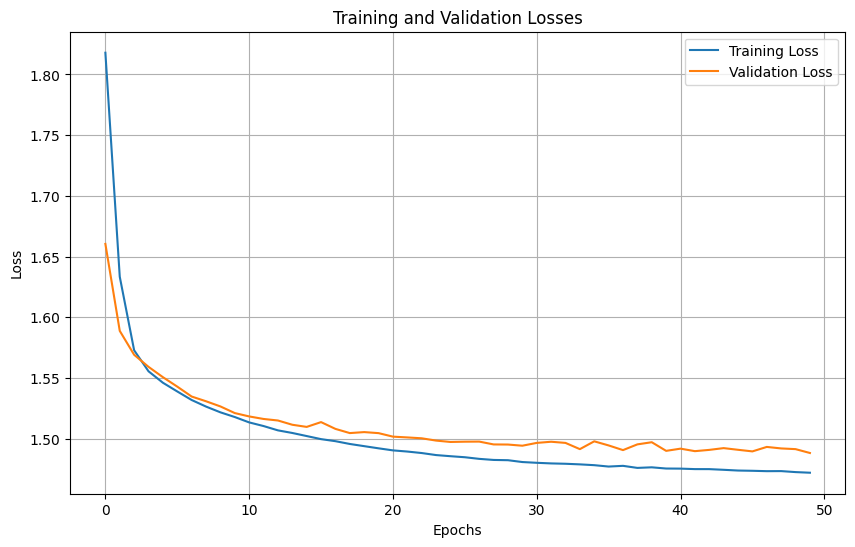

Test Loss: 1.4880, Accuracy: 0.9731, F1 Score: 0.9731
Experiment 1 Results:
Test Loss: 1.4880
Accuracy: 0.9731
F1 Score: 0.9731


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Initialize the model
model_1 = Model(
    input_dim=model_1_config["input_dim"],
    hidden_dim=model_1_config["hidden_dim"],
    out_dim=model_1_config["out_dim"],
    num_layers=model_1_config["num_layers"],
    dropout=model_1_config["dropout"],
    dropout_p=model_1_config["dropout_p"]
)

# Ensure the model runs on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_1.to(device)
model_1.device = device  # Explicitly set the device attribute for compatibility

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
model_1, train_losses, val_losses = trainer(
    model=model_1,
    train_loader=train_dl,
    val_loader=val_dl,
    criterion=criterion,
    optimizer=optimizer,
    epochs=50,
    early_stopping=False
)

# Plot the training and validation losses
plot_losses(train_losses, val_losses)

# Evaluate the model on the test set
avg_test_loss, accuracy, f1 = evaluate_model(model_1, test_dl, criterion)

# Print the results
print(f"Experiment 1 Results:\nTest Loss: {avg_test_loss:.4f}\nAccuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}")

### Experiment 2: Deep regularized network (with weight-decay enabled)

Use the given model configs to run the experiments.

In [8]:
# Deep network (3 hidden layers) with weight-decay but no dropout
model_2_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}


learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

Epoch 1/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 68.99it/s]


Epoch 1/50: Train Loss = 1.8033, Val Loss = 1.6128


Epoch 2/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.04it/s]


Epoch 2/50: Train Loss = 1.5887, Val Loss = 1.5735


Epoch 3/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 71.64it/s]


Epoch 3/50: Train Loss = 1.5665, Val Loss = 1.5648


Epoch 4/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.91it/s]


Epoch 4/50: Train Loss = 1.5552, Val Loss = 1.5589


Epoch 5/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 62.02it/s]


Epoch 5/50: Train Loss = 1.5471, Val Loss = 1.5462


Epoch 6/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 58.17it/s]


Epoch 6/50: Train Loss = 1.5391, Val Loss = 1.5393


Epoch 7/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.36it/s]


Epoch 7/50: Train Loss = 1.5330, Val Loss = 1.5389


Epoch 8/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.48it/s]


Epoch 8/50: Train Loss = 1.5277, Val Loss = 1.5321


Epoch 9/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.61it/s]


Epoch 9/50: Train Loss = 1.5233, Val Loss = 1.5301


Epoch 10/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 58.32it/s]


Epoch 10/50: Train Loss = 1.5195, Val Loss = 1.5251


Epoch 11/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 63.88it/s]


Epoch 11/50: Train Loss = 1.5155, Val Loss = 1.5182


Epoch 12/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.56it/s]


Epoch 12/50: Train Loss = 1.5119, Val Loss = 1.5201


Epoch 13/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.46it/s]


Epoch 13/50: Train Loss = 1.5089, Val Loss = 1.5271


Epoch 14/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.44it/s]


Epoch 14/50: Train Loss = 1.5066, Val Loss = 1.5132


Epoch 15/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 66.59it/s]


Epoch 15/50: Train Loss = 1.5039, Val Loss = 1.5126


Epoch 16/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 57.76it/s]


Epoch 16/50: Train Loss = 1.5017, Val Loss = 1.5112


Epoch 17/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.89it/s]


Epoch 17/50: Train Loss = 1.4994, Val Loss = 1.5095


Epoch 18/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.28it/s]


Epoch 18/50: Train Loss = 1.4974, Val Loss = 1.5053


Epoch 19/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.38it/s]


Epoch 19/50: Train Loss = 1.4955, Val Loss = 1.5066


Epoch 20/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 66.63it/s]


Epoch 20/50: Train Loss = 1.4942, Val Loss = 1.5026


Epoch 21/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 56.80it/s]


Epoch 21/50: Train Loss = 1.4927, Val Loss = 1.5047


Epoch 22/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.03it/s]


Epoch 22/50: Train Loss = 1.4913, Val Loss = 1.5020


Epoch 23/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.87it/s]


Epoch 23/50: Train Loss = 1.4899, Val Loss = 1.4998


Epoch 24/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.56it/s]


Epoch 24/50: Train Loss = 1.4881, Val Loss = 1.5002


Epoch 25/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 66.36it/s]


Epoch 25/50: Train Loss = 1.4871, Val Loss = 1.5016


Epoch 26/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 48.14it/s]


Epoch 26/50: Train Loss = 1.4862, Val Loss = 1.4982


Epoch 27/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.75it/s]


Epoch 27/50: Train Loss = 1.4851, Val Loss = 1.5003


Epoch 28/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.35it/s]


Epoch 28/50: Train Loss = 1.4834, Val Loss = 1.5026


Epoch 29/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.78it/s]


Epoch 29/50: Train Loss = 1.4835, Val Loss = 1.4981


Epoch 30/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.84it/s]


Epoch 30/50: Train Loss = 1.4830, Val Loss = 1.4974


Epoch 31/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 56.69it/s]


Epoch 31/50: Train Loss = 1.4819, Val Loss = 1.4942


Epoch 32/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.50it/s]


Epoch 32/50: Train Loss = 1.4814, Val Loss = 1.4948


Epoch 33/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.61it/s]


Epoch 33/50: Train Loss = 1.4809, Val Loss = 1.4973


Epoch 34/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.23it/s]


Epoch 34/50: Train Loss = 1.4799, Val Loss = 1.5014


Epoch 35/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.62it/s]


Epoch 35/50: Train Loss = 1.4797, Val Loss = 1.4941


Epoch 36/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 67.03it/s]


Epoch 36/50: Train Loss = 1.4789, Val Loss = 1.4935


Epoch 37/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 55.61it/s]


Epoch 37/50: Train Loss = 1.4783, Val Loss = 1.4935


Epoch 38/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.24it/s]


Epoch 38/50: Train Loss = 1.4779, Val Loss = 1.4919


Epoch 39/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.52it/s]


Epoch 39/50: Train Loss = 1.4769, Val Loss = 1.4933


Epoch 40/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.47it/s]


Epoch 40/50: Train Loss = 1.4766, Val Loss = 1.4910


Epoch 41/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.92it/s]


Epoch 41/50: Train Loss = 1.4767, Val Loss = 1.4910


Epoch 42/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 54.96it/s]


Epoch 42/50: Train Loss = 1.4761, Val Loss = 1.4902


Epoch 43/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.51it/s]


Epoch 43/50: Train Loss = 1.4753, Val Loss = 1.4925


Epoch 44/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.23it/s]


Epoch 44/50: Train Loss = 1.4752, Val Loss = 1.4920


Epoch 45/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.02it/s]


Epoch 45/50: Train Loss = 1.4743, Val Loss = 1.4910


Epoch 46/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.22it/s]


Epoch 46/50: Train Loss = 1.4747, Val Loss = 1.4926


Epoch 47/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 62.13it/s]


Epoch 47/50: Train Loss = 1.4741, Val Loss = 1.4908


Epoch 48/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 61.00it/s]


Epoch 48/50: Train Loss = 1.4737, Val Loss = 1.4929


Epoch 49/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.09it/s]


Epoch 49/50: Train Loss = 1.4737, Val Loss = 1.4924


Epoch 50/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.03it/s]


Epoch 50/50: Train Loss = 1.4735, Val Loss = 1.4905


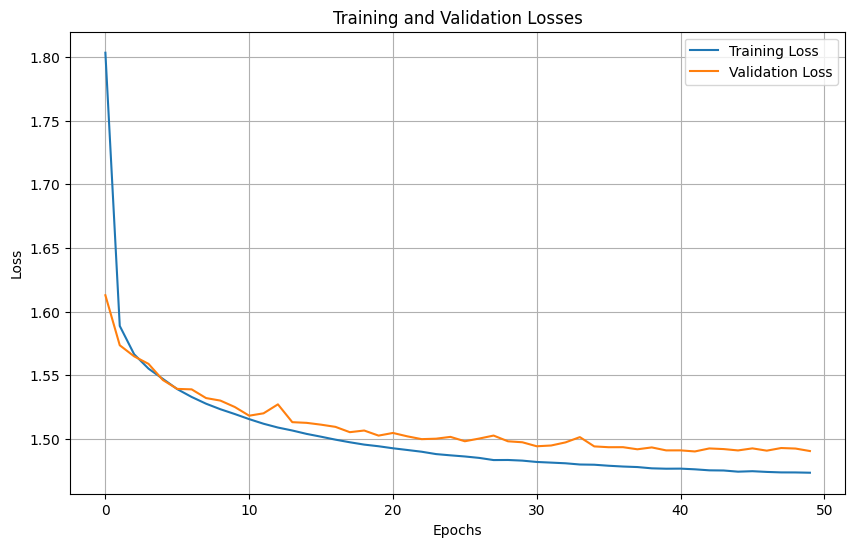

Test Loss: 1.4892, Accuracy: 0.9728, F1 Score: 0.9728
Experiment 2 Results:
Test Loss: 1.4892
Accuracy: 0.9728
F1 Score: 0.9728


In [9]:
# Initialize the model
model_2 = Model(
    input_dim=model_2_config["input_dim"],
    hidden_dim=model_2_config["hidden_dim"],
    out_dim=model_2_config["out_dim"],
    num_layers=model_2_config["num_layers"],
    dropout=model_2_config["dropout"],
    dropout_p=model_2_config["dropout_p"]
)

model_2.to(device)
model_2.device = device  # Explicitly set the device attribute


optimizer_2 = optim.Adam(model_2.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
model_2, train_losses_2, val_losses_2 = trainer(
    model=model_2,
    train_loader=train_dl,
    val_loader=val_dl,
    criterion=criterion,
    optimizer=optimizer_2,
    epochs=50,
    early_stopping=False
)

# Plot the training and validation losses
plot_losses(train_losses_2, val_losses_2)

# Evaluate the model on the test set
avg_test_loss_2, accuracy_2, f1_2 = evaluate_model(model_2, test_dl, criterion)

# Print the results
print(f"Experiment 2 Results:\nTest Loss: {avg_test_loss_2:.4f}\nAccuracy: {accuracy_2:.4f}\nF1 Score: {f1_2:.4f}")

### Experiment 3: Deep regularized network (with weight-decay and dropout)

Use the given model configs to run the experiments.

In [10]:
# Deep regularized network (3 hidden layers) with weight-decay and dropout after every layer
model_3_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [True, True, True],
    "dropout_p": 0.5
}

learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

Epoch 1/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.34it/s]


Epoch 1/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 2/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 56.80it/s]


Epoch 2/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 3/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 62.20it/s]


Epoch 3/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 4/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.73it/s]


Epoch 4/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 5/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.70it/s]


Epoch 5/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 6/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.78it/s]


Epoch 6/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 7/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 77.09it/s]


Epoch 7/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 8/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.68it/s]


Epoch 8/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 9/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 55.01it/s]


Epoch 9/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 10/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 56.74it/s]


Epoch 10/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 11/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.53it/s]


Epoch 11/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 12/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.75it/s]


Epoch 12/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 13/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.32it/s]


Epoch 13/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 14/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.76it/s]


Epoch 14/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 15/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.81it/s]


Epoch 15/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 16/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 67.03it/s]


Epoch 16/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 17/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 56.52it/s]


Epoch 17/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 18/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 70.78it/s]


Epoch 18/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 19/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.65it/s]


Epoch 19/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 20/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.27it/s]


Epoch 20/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 21/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.47it/s]


Epoch 21/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 22/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.68it/s]


Epoch 22/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 23/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 59.76it/s]


Epoch 23/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 24/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 62.08it/s]


Epoch 24/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 25/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.23it/s]


Epoch 25/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 26/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.39it/s]


Epoch 26/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 27/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.77it/s]


Epoch 27/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 28/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.78it/s]


Epoch 28/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 29/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 64.81it/s]


Epoch 29/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 30/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 58.16it/s]


Epoch 30/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 31/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.29it/s]


Epoch 31/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 32/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.70it/s]


Epoch 32/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 33/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.32it/s]


Epoch 33/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 34/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.87it/s]


Epoch 34/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 35/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.33it/s]


Epoch 35/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 36/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 66.24it/s]


Epoch 36/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 37/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 60.85it/s]


Epoch 37/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 38/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.78it/s]


Epoch 38/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 39/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.62it/s]


Epoch 39/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 40/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.08it/s]


Epoch 40/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 41/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.24it/s]


Epoch 41/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 42/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 73.48it/s]


Epoch 42/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 43/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 59.03it/s]


Epoch 43/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 44/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.10it/s]


Epoch 44/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 45/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.27it/s]


Epoch 45/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 46/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.68it/s]


Epoch 46/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 47/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.46it/s]


Epoch 47/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 48/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.90it/s]


Epoch 48/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 49/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 62.41it/s]


Epoch 49/50: Train Loss = 2.3025, Val Loss = 2.3025


Epoch 50/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 60.27it/s]


Epoch 50/50: Train Loss = 2.3025, Val Loss = 2.3025


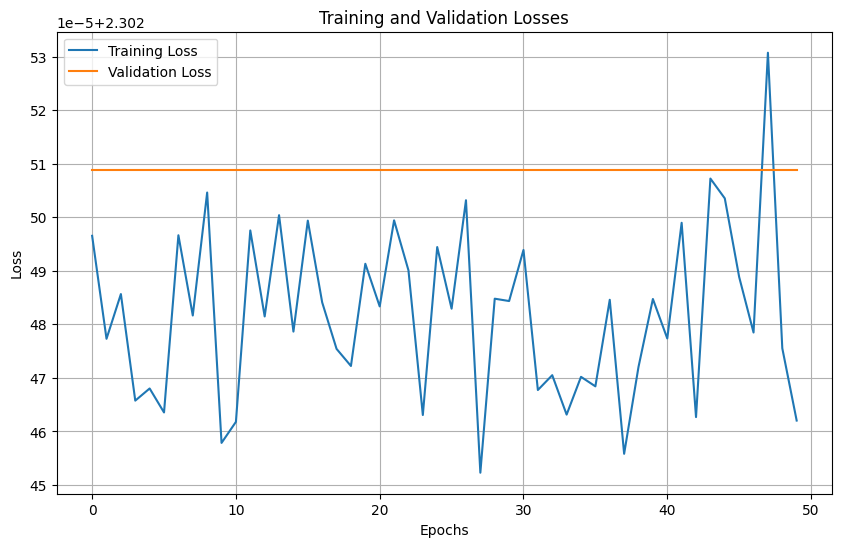

Test Loss: 2.3025, Accuracy: 0.1162, F1 Score: 0.0282
Experiment 3 Results:
Test Loss: 2.3025
Accuracy: 0.1162
F1 Score: 0.0282


In [11]:
# Initialize the model
model_3 = Model(
    input_dim=model_3_config["input_dim"],
    hidden_dim=model_3_config["hidden_dim"],
    out_dim=model_3_config["out_dim"],
    num_layers=model_3_config["num_layers"],
    dropout=model_3_config["dropout"],
    dropout_p=model_3_config["dropout_p"]
)

model_3.to(device)
model_3.device = device  # Explicitly set the device attribute


optimizer_3 = optim.Adam(model_3.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
model_3, train_losses_3, val_losses_3 = trainer(
    model=model_3,
    train_loader=train_dl,
    val_loader=val_dl,
    criterion=criterion,
    optimizer=optimizer_2,
    epochs=50,
    early_stopping=False
)

# Plot the training and validation losses
plot_losses(train_losses_3, val_losses_3)

# Evaluate the model on the test set
avg_test_loss_3, accuracy_3, f1_3 = evaluate_model(model_3, test_dl, criterion)

# Print the results
print(f"Experiment 3 Results:\nTest Loss: {avg_test_loss_3:.4f}\nAccuracy: {accuracy_3:.4f}\nF1 Score: {f1_3:.4f}")

### Experiment 4: Deep regularized network (with weight-decay and early-stopping)

Use the given model configs to run the experiments.

In [12]:
# Deep regularized network (3 hidden layers) with weight-decay and early stopping
model_4_config = {
    "input_dim": 28 * 28,
    "hidden_dim": 400,
    "out_dim": 10,
    "num_layers": 3,
    "dropout": [False, False, False],
    "dropout_p": 0.5
}

learning_rate = 5e-5
weight_decay = 1e-4  # Use this only if weight-decay is needed

Epoch 1/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.52it/s]


Epoch 1/50: Train Loss = 1.8434, Val Loss = 1.6409


Epoch 2/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.33it/s]


Epoch 2/50: Train Loss = 1.6009, Val Loss = 1.5768


Epoch 3/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.15it/s]


Epoch 3/50: Train Loss = 1.5692, Val Loss = 1.5753


Epoch 4/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 60.26it/s]


Epoch 4/50: Train Loss = 1.5567, Val Loss = 1.5535


Epoch 5/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 62.49it/s]


Epoch 5/50: Train Loss = 1.5477, Val Loss = 1.5465


Epoch 6/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.37it/s]


Epoch 6/50: Train Loss = 1.5408, Val Loss = 1.5408


Epoch 7/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.31it/s]


Epoch 7/50: Train Loss = 1.5341, Val Loss = 1.5376


Epoch 8/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.71it/s]


Epoch 8/50: Train Loss = 1.5286, Val Loss = 1.5305


Epoch 9/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 52.61it/s]


Epoch 9/50: Train Loss = 1.5238, Val Loss = 1.5280


Epoch 10/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 51.04it/s]


Epoch 10/50: Train Loss = 1.5192, Val Loss = 1.5258


Epoch 11/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.18it/s]


Epoch 11/50: Train Loss = 1.5163, Val Loss = 1.5246


Epoch 12/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.91it/s]


Epoch 12/50: Train Loss = 1.5121, Val Loss = 1.5174


Epoch 13/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.49it/s]


Epoch 13/50: Train Loss = 1.5095, Val Loss = 1.5151


Epoch 14/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 65.92it/s]


Epoch 14/50: Train Loss = 1.5074, Val Loss = 1.5148


Epoch 15/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 59.04it/s]


Epoch 15/50: Train Loss = 1.5038, Val Loss = 1.5132


Epoch 16/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.97it/s]


Epoch 16/50: Train Loss = 1.5021, Val Loss = 1.5117


Epoch 17/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.62it/s]


Epoch 17/50: Train Loss = 1.4996, Val Loss = 1.5084


Epoch 18/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 72.50it/s]


Epoch 18/50: Train Loss = 1.4978, Val Loss = 1.5081


Epoch 19/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.74it/s]


Epoch 19/50: Train Loss = 1.4959, Val Loss = 1.5053


Epoch 20/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 63.67it/s]


Epoch 20/50: Train Loss = 1.4947, Val Loss = 1.5028


Epoch 21/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 61.74it/s]


Epoch 21/50: Train Loss = 1.4928, Val Loss = 1.5025


Epoch 22/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.41it/s]


Epoch 22/50: Train Loss = 1.4909, Val Loss = 1.5088


Epoch 23/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.47it/s]


Epoch 23/50: Train Loss = 1.4900, Val Loss = 1.5060


Epoch 24/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.97it/s]


Epoch 24/50: Train Loss = 1.4887, Val Loss = 1.5007


Epoch 25/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 54.77it/s]


Epoch 25/50: Train Loss = 1.4867, Val Loss = 1.4979


Epoch 26/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 57.10it/s]


Epoch 26/50: Train Loss = 1.4855, Val Loss = 1.4971


Epoch 27/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.51it/s]


Epoch 27/50: Train Loss = 1.4844, Val Loss = 1.4997


Epoch 28/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.85it/s]


Epoch 28/50: Train Loss = 1.4841, Val Loss = 1.4982


Epoch 29/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.95it/s]


Epoch 29/50: Train Loss = 1.4830, Val Loss = 1.4975


Epoch 30/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.14it/s]


Epoch 30/50: Train Loss = 1.4818, Val Loss = 1.4940


Epoch 31/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 68.50it/s]


Epoch 31/50: Train Loss = 1.4815, Val Loss = 1.4937


Epoch 32/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 56.07it/s]


Epoch 32/50: Train Loss = 1.4807, Val Loss = 1.4938


Epoch 33/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.45it/s]


Epoch 33/50: Train Loss = 1.4796, Val Loss = 1.4995


Epoch 34/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.27it/s]


Epoch 34/50: Train Loss = 1.4794, Val Loss = 1.4949


Epoch 35/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.78it/s]


Epoch 35/50: Train Loss = 1.4790, Val Loss = 1.4993


Epoch 36/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 77.45it/s]


Epoch 36/50: Train Loss = 1.4782, Val Loss = 1.4950


Epoch 37/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 70.46it/s]


Epoch 37/50: Train Loss = 1.4775, Val Loss = 1.4925


Epoch 38/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 57.73it/s]


Epoch 38/50: Train Loss = 1.4770, Val Loss = 1.4928


Epoch 39/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.88it/s]


Epoch 39/50: Train Loss = 1.4766, Val Loss = 1.4959


Epoch 40/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.60it/s]


Epoch 40/50: Train Loss = 1.4768, Val Loss = 1.4894


Epoch 41/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 60.94it/s]


Epoch 41/50: Train Loss = 1.4756, Val Loss = 1.4918


Epoch 42/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 76.71it/s]


Epoch 42/50: Train Loss = 1.4754, Val Loss = 1.4922


Epoch 43/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 66.48it/s]


Epoch 43/50: Train Loss = 1.4753, Val Loss = 1.4906


Epoch 44/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 59.11it/s]


Epoch 44/50: Train Loss = 1.4751, Val Loss = 1.4929


Epoch 45/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.77it/s]


Epoch 45/50: Train Loss = 1.4741, Val Loss = 1.4904


Epoch 46/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 74.80it/s]


Epoch 46/50: Train Loss = 1.4741, Val Loss = 1.4900


Epoch 47/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 75.76it/s]


Epoch 47/50: Train Loss = 1.4734, Val Loss = 1.4905


Epoch 48/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 77.11it/s]


Epoch 48/50: Train Loss = 1.4734, Val Loss = 1.4926


Epoch 49/50 - Validation: 100%|██████████| 188/188 [00:02<00:00, 69.30it/s]


Epoch 49/50: Train Loss = 1.4730, Val Loss = 1.4898


Epoch 50/50 - Validation: 100%|██████████| 188/188 [00:03<00:00, 56.32it/s]


Epoch 50/50: Train Loss = 1.4729, Val Loss = 1.4902


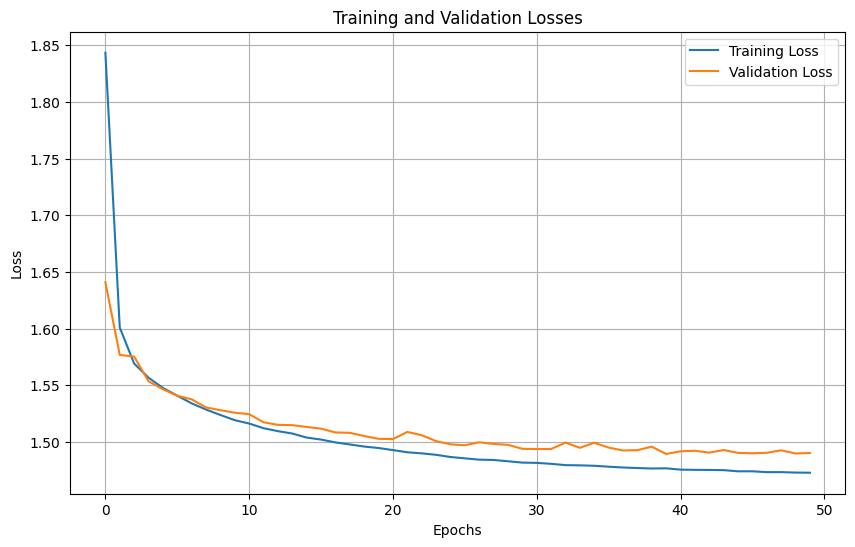

Test Loss: 1.4861, Accuracy: 0.9765, F1 Score: 0.9765
Experiment 4 Results:
Test Loss: 1.4861
Accuracy: 0.9765
F1 Score: 0.9765


In [13]:
# Initialize the model
model_4 = Model(
    input_dim=model_4_config["input_dim"],
    hidden_dim=model_4_config["hidden_dim"],
    out_dim=model_4_config["out_dim"],
    num_layers=model_4_config["num_layers"],
    dropout=model_4_config["dropout"],
    dropout_p=model_4_config["dropout_p"]
)

model_4.to(device)
model_4.device = device  # Explicitly set the device attribute


optimizer_4 = optim.Adam(model_4.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Train the model
model_4, train_losses_4, val_losses_4 = trainer(
    model=model_4,
    train_loader=train_dl,
    val_loader=val_dl,
    criterion=criterion,
    optimizer=optimizer_4,
    epochs=50,
    early_stopping=False
)

# Plot the training and validation losses
plot_losses(train_losses_4, val_losses_4)

# Evaluate the model on the test set
avg_test_loss_4, accuracy_4, f1_4 = evaluate_model(model_4, test_dl, criterion)

# Print the results
print(f"Experiment 4 Results:\nTest Loss: {avg_test_loss_4:.4f}\nAccuracy: {accuracy_4:.4f}\nF1 Score: {f1_4:.4f}")

In [17]:
#Report the model accuracies and F1-score on the test set
import pandas as pd
# Evaluate the model on the test set
avg_test_loss, accuracy, f1 = evaluate_model(model_4, test_dl, criterion)

# Print the results
print(f"Results:\nTest Loss: {avg_test_loss:.4f}\nAccuracy: {accuracy:.4f}\nF1 Score: {f1:.4f}")

# Report results in a table
results = pd.DataFrame({
    "Experiment": ["Experiment 1", "Experiment 2", "Experiment 3", "Experiment 4"],
    "Test Loss": [avg_test_loss, avg_test_loss_2, avg_test_loss_3, avg_test_loss_4],
    "Accuracy": [accuracy, accuracy_2, accuracy_3, accuracy_4],
    "F1 Score": [f1, f1_2, f1_3, f1_4]
})

print("\nFinal Results:")
print(results)

Test Loss: 1.4861, Accuracy: 0.9765, F1 Score: 0.9765
Results:
Test Loss: 1.4861
Accuracy: 0.9765
F1 Score: 0.9765

Final Results:
     Experiment  Test Loss  Accuracy  F1 Score
0  Experiment 1   1.486103    0.9765  0.976486
1  Experiment 2   1.486103    0.9765  0.976486
2  Experiment 3   2.302460    0.1162  0.028168
3  Experiment 4   1.486103    0.9765  0.976486
